In [ ]:
import json
import os
from collections import Counter
import random

keywords = ["wait", "alternatively", "hmm"]

def show_budget(files, path = '/expert/think_budget_collect', suffix='.jsonl'):
    for file in files:
        correct = 0
        total = 0
        total_len = 0
        total_keyword_count = 0  

        file_path = os.path.join(path, file + suffix)
        if not os.path.exists(file_path):
            print(f"Missing: {file}")
            continue

        with open(file_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                data = json.loads(line)
                total += 1
                total_len += data.get("len", 0)
                if data.get("correct", False):
                    correct += 1

                text = (data.get("generated_text", "")).lower()
                for kw in keywords:
                    total_keyword_count += text.count(kw)

        acc = correct / total if total > 0 else 0
        avg_len = total_len / total if total > 0 else 0
        print(f"  acc={acc:.3f}, avg_len={avg_len:.2f}, total={total}, wait_count={total_keyword_count} : {file}")


In [ ]:
import os, json

keywords = ["wait", "alternatively", "hmm"]

def show_vllm_budget(files, path='/expert/no_think_collect', suffix='.json'):
    for file in files:
        correct = 0
        total = 0
        total_len = 0
        total_keyword_count = 0

        file_path = os.path.join(path, file + suffix)
        if not os.path.exists(file_path):
            print(f"Missing: {file}")
            continue

        with open(file_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue

                data = json.loads(line)

                if data.get("len", 0) < 10:
                    continue

                total += 1
                total_len += data.get("len", 0)

                if data.get("correct", False):
                    correct += 1

                text = (data.get("generated_text", "")).lower()
                for kw in keywords:
                    total_keyword_count += text.count(kw)

        acc = correct / total if total > 0 else 0
        avg_len = total_len / total if total > 0 else 0

        print(f"  acc={acc:.3f}, avg_len={avg_len:.2f}, total={total}, wait_count={total_keyword_count} : {file}")

In [ ]:
import os, json
import matplotlib.pyplot as plt

keywords = ["wait", "alternatively", "hmm"]

def parse_result(file, path, suffix=".json"):
    correct = 0
    total = 0
    total_len = 0
    total_keyword_count = 0

    file_path = os.path.join(path, file + suffix)
    if not os.path.exists(file_path):
        print(f"Missing: {file}")
        return None

    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue

            data = json.loads(line)

            if data.get("len", 0) < 10:
                continue

            total += 1
            total_len += data.get("len", 0)

            if data.get("correct", False):
                correct += 1

            text = (data.get("generated_text", "")).lower()
            for kw in keywords:
                total_keyword_count += text.count(kw)

    if total == 0:
        return None

    acc = correct / total
    avg_len = total_len / total
    return acc, avg_len, total_keyword_count, True


def draw_vllm_budget(model, files, path, suffix=".json"):
    results = {}  

    print("=== Results ===")
    for file in files:
        parsed = parse_result(file, path, suffix)
        if parsed is None:
            print(f"Missing or empty: {file}")
            continue

        acc, avg_len, kw_count, _ = parsed
        results[file] = (acc, avg_len)

        print(f"acc={acc:.3f}, avg_len={avg_len:.1f}, wait_count={kw_count} : {file}")

    budget_x = []
    budget_y = []
    budget_labels = []

    special_x = []
    special_y = []
    special_labels = []

    for file, (acc, avg_len) in results.items():
        if "<begin>" in file or "<reason>" in file or "<less think>" in file:
            special_x.append(avg_len)
            special_y.append(acc)
            special_labels.append(file)
            continue

        if "budget" in file:
            try:
                b = float(file.split("budget")[-1])
            except:
                continue

            if "_False__budget1.0" in file:
                b = 0.0

            budget_x.append(avg_len)
            budget_y.append(acc)
            budget_labels.append(b)

    sorted_idx = sorted(range(len(budget_labels)), key=lambda i: budget_labels[i])
    budget_x_sorted = [budget_x[i] for i in sorted_idx]
    budget_y_sorted = [budget_y[i] for i in sorted_idx]
    budget_label_sorted = [budget_labels[i] for i in sorted_idx]
    plt.figure(figsize=(6, 3))

    plt.plot(budget_x_sorted, budget_y_sorted, marker="o", linewidth=2, label="Budget Curve")

    plt.scatter(special_x, special_y, s=80, color="red", label="Special Prompts")

    for x, y, label in zip(special_x, special_y, special_labels):
        plt.text(x, y, label.replace(model, ""), fontsize=8)

    plt.xlabel("Avg Token Length")
    plt.ylabel("Accuracy")
    plt.title(f"{model} — Budget vs. Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

## overview result

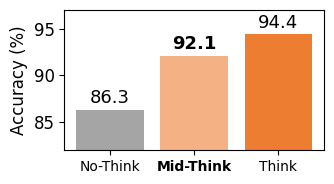

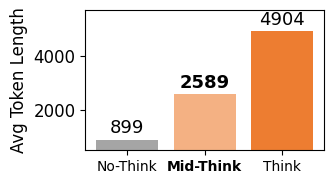

In [14]:
import matplotlib.pyplot as plt

methods = ["No-Think", "Mid-Think", "Think"]
acc = [86.3, 92.1, 94.4]
avg_len = [899, 2589, 4904]

COLORS = {
    "Think": "#ED7D31",
    "No-Think": "#A5A5A5",
    "Mid-Think": "#F4B183",
}

plt.rcParams.update({
    "font.size": 12,
    "axes.linewidth": 0.8,
})

def set_xticks_bold_midthink(ax, methods, fontsize=12):
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontsize=fontsize)
    for tick, m in zip(ax.get_xticklabels(), methods):
        tick.set_fontweight("bold" if m == "Mid-Think" else "normal")

def add_bar_labels(bars, values, methods, y_offset, mid_fs=13, other_fs=10):
    for bar, val, m in zip(bars, values, methods):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            val + y_offset,
            f"{val:.1f}" if isinstance(val, float) else f"{val}",
            ha="center",
            va="bottom",
            fontsize=mid_fs if m == "Mid-Think" else other_fs,
            fontweight="bold" if m == "Mid-Think" else "normal",
        )

# -------------------- Accuracy --------------------
plt.figure(figsize=(3.5, 2))
bars = plt.bar(methods, acc, color=[COLORS[m] for m in methods])

ax = plt.gca()
set_xticks_bold_midthink(ax, methods, fontsize=10)

plt.ylabel("Accuracy (%)")
plt.ylim(82, 97)

# labels (Mid-Think bigger + bold)
for bar, val, m in zip(bars, acc, methods):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.3,
        f"{val:.1f}",
        ha="center",
        va="bottom",
        fontsize=13 if m == "Mid-Think" else 13,
        fontweight="bold" if m == "Mid-Think" else "normal",
    )

plt.tight_layout()
plt.savefig("/home/wxy320/ondemand/program/gpt-oss/no_think/attn/acc_bar.pdf", dpi=600)
plt.show()

# -------------------- Avg Length --------------------
plt.figure(figsize=(3.5, 2))
bars = plt.bar(methods, avg_len, color=[COLORS[m] for m in methods])

ax = plt.gca()
set_xticks_bold_midthink(ax, methods, fontsize=10)

plt.ylabel("Avg Token Length")
plt.ylim(500, 5700)

# labels (Mid-Think bigger + bold)
for bar, val, m in zip(bars, avg_len, methods):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 80,
        f"{val}",
        ha="center",
        va="bottom",
        fontsize=13 if m == "Mid-Think" else 13,
        fontweight="bold" if m == "Mid-Think" else "normal",
    )

plt.tight_layout()
plt.savefig("/home/wxy320/ondemand/program/gpt-oss/no_think/attn/length_bar.pdf", dpi=600)
plt.show()

## fixed-token results

In [ ]:
model = 'Qwen3-8B'
path = '/expert/no_think_fix'
files = [
        f"{model}_MATH-500_budget2048",
        f"{model}_MATH-500_budget3072",
        f"{model}_MATH-500_budget4096",
        f"{model}_MATH-500_budget5120",
        f"{model}_MATH-500_budget6144",
    ]
show_budget(files, path=path)
# Considering the limited time by the user, I have to give the solution based on the thinking directly now.\n</think>.\n\n

  acc=0.882, avg_len=2758.65, total=500, wait_count=6046 : Qwen3-8B_MATH-500_budget2048
  acc=0.898, avg_len=3490.54, total=500, wait_count=8603 : Qwen3-8B_MATH-500_budget3072
  acc=0.894, avg_len=4018.95, total=500, wait_count=10097 : Qwen3-8B_MATH-500_budget4096
  acc=0.914, avg_len=4389.91, total=500, wait_count=11266 : Qwen3-8B_MATH-500_budget5120
Missing: Qwen3-8B_MATH-500_budget6144


In [5]:
model = 'Qwen3-14B'
files = [
        f"{model}_MATH-500_budget2048",
        f"{model}_MATH-500_budget3072",
        f"{model}_MATH-500_budget4096",
        f"{model}_MATH-500_budget5120",
        f"{model}_MATH-500_budget6144",
    ]
show_budget(files, path=path)
# Considering the limited time by the user, I have to give the solution based on the thinking directly now.\n</think>.\n\n

  acc=0.896, avg_len=2673.69, total=500, wait_count=5155 : Qwen3-14B_MATH-500_budget2048
  acc=0.912, avg_len=3315.87, total=500, wait_count=6875 : Qwen3-14B_MATH-500_budget3072
  acc=0.908, avg_len=3793.64, total=500, wait_count=7985 : Qwen3-14B_MATH-500_budget4096
  acc=0.922, avg_len=4136.19, total=490, wait_count=8801 : Qwen3-14B_MATH-500_budget5120
Missing: Qwen3-14B_MATH-500_budget6144
